In [ ]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, recall_score
) 

data = pd.read_csv('data.csv')

In [11]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB
None


In [ ]:
print(data.Gender.unique(), data.Vehicle_Age.unique(), data.Vehicle_Damage.unique())

['Male' 'Female'] ['1-2 Year' '> 2 Years' '< 1 Year'] ['Yes' 'No']


In [ ]:
print(data.isna().mean())

id                      0.0
Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
Response                0.0
dtype: float64


In [2]:
# Удаляем ненужные столбцы
data = data.drop(columns=['id'])

# Применяем метод one-hot-encode
data = pd.get_dummies(
    data, columns=['Gender', 'Vehicle_Damage'], 
    drop_first=True,
    )
data = data.rename(columns={'Gender_Male': 'Male', 'Vehicle_Damage_Yes': 'Vehicle_Damage'})
data['Male'] = data['Male'].astype(int)
data['Vehicle_Damage'] = data['Vehicle_Damage'].astype(int)

# Применяем OrdinalEncoder к признакам с иерархией
ordinalencoder = OrdinalEncoder(categories = [['< 1 Year', '1-2 Year', '> 2 Years']])
data['Vehicle_Age'] = ordinalencoder.fit_transform(data['Vehicle_Age'].to_frame())

print(data.head())

   Age  Driving_License  Region_Code  Previously_Insured  Vehicle_Age  \
0   21                1         35.0                   0          1.0   
1   43                1         28.0                   0          2.0   
2   25                1         14.0                   1          0.0   
3   35                1          1.0                   0          1.0   
4   36                1         15.0                   1          1.0   

   Annual_Premium  Policy_Sales_Channel  Vintage  Response  Male  \
0         65101.0                 124.0      187         0     1   
1         58911.0                  26.0      288         1     1   
2         38043.0                 152.0      254         0     0   
3          2630.0                 156.0       76         0     0   
4         31951.0                 152.0      294         0     0   

   Vehicle_Damage  
0               1  
1               1  
2               0  
3               1  
4               0  


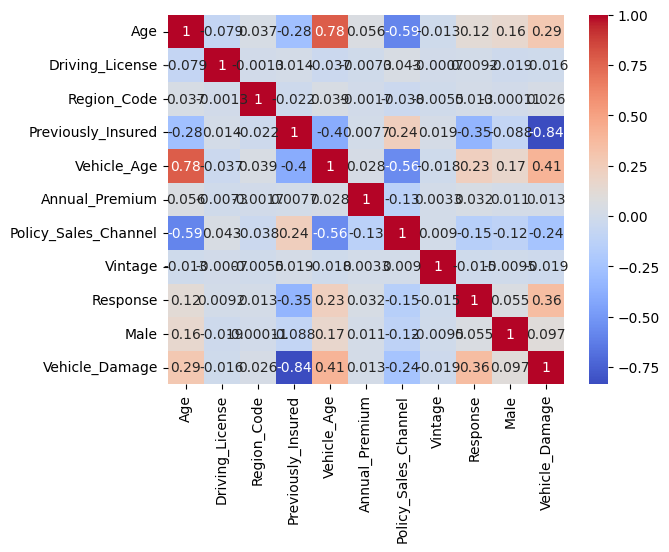

In [7]:
sns.heatmap(data.corr(), cmap='coolwarm', annot=True);

In [8]:
print(data.describe())

                Age  Driving_License   Region_Code  Previously_Insured  \
count  1.150480e+07     1.150480e+07  1.150480e+07        1.150480e+07   
mean   3.838356e+01     9.980220e-01  2.641869e+01        4.629966e-01   
std    1.499346e+01     4.443120e-02  1.299159e+01        4.986289e-01   
min    2.000000e+01     0.000000e+00  0.000000e+00        0.000000e+00   
25%    2.400000e+01     1.000000e+00  1.500000e+01        0.000000e+00   
50%    3.600000e+01     1.000000e+00  2.800000e+01        0.000000e+00   
75%    4.900000e+01     1.000000e+00  3.500000e+01        1.000000e+00   
max    8.500000e+01     1.000000e+00  5.200000e+01        1.000000e+00   

        Vehicle_Age  Annual_Premium  Policy_Sales_Channel       Vintage  \
count  1.150480e+07    1.150480e+07          1.150480e+07  1.150480e+07   
mean   6.031073e-01    3.046137e+04          1.124254e+02  1.638977e+02   
std    5.678559e-01    1.645475e+04          5.403571e+01  7.997953e+01   
min    0.000000e+00    2.630000e+

In [3]:
y = data['Response']
X = data.drop(columns=['Response'])

# Стандартизация
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение данных
(X_train, X_test,
y_train, y_test) = train_test_split(X, y, train_size=0.5, stratify=y, random_state=42)

In [ ]:
# Натсроим кросс-валидацию с стратификацией
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Подбор гиперпараметров

# KNC parameters
param_dist_knc = {
    'n_neighbors': randint(3, 51),
    'weights': ['uniform', 'distance'],
    'p': randint(1, 3),
    'metric': ['euclidean', 'manhattan', 'minkowski']             
}

# DTC parameters
param_dist_dtc = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25, None],
    'min_samples_split': randint(2, 21),
    'min_samples_leaf': randint(1, 11),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42]
}

# RFC parameters
param_dist_rfc = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

random_knc = RandomizedSearchCV(KNeighborsClassifier(), param_dist_knc, 
                               n_iter=5, cv=skf, scoring='roc_auc', verbose=2)
random_knc.fit(X_train, y_train)
print("Лучшие параметры kNC:", random_knc.best_params_, "ROC AUC:", random_knc.best_score_)

random_dtc = RandomizedSearchCV(DecisionTreeClassifier(), param_dist_dtc, 
                               n_iter=5, cv=skf, scoring='roc_auc', verbose=2)
random_dtc.fit(X_train, y_train)
print("Лучшие параметры DTC:", random_dtc.best_params_, "ROC AUC:", random_dtc.best_score_)

random_rfc = RandomizedSearchCV(RandomForestClassifier(), param_dist_rfc, 
                               n_iter=5, cv=skf, scoring='roc_auc', verbose=2)
random_rfc.fit(X_train, y_train)
print("Лучшие параметры RFC:", random_rfc.best_params_, "ROC AUC:", random_rfc.best_score_)

# Финальные параметры
best_params_knc = random_knc.best_estimator_
best_params_dtc = random_dtc.best_estimator_
best_params_rfc = random_rfc.best_estimator_

In [ ]:
models = {
    'kNC': KNeighborsClassifier(**best_params_knc),
    'DFC': DecisionTreeClassifier(**best_params_dtc),
    'RFC': RandomForestClassifier(**best_params_rfc),
}

# Поиск оптимального порога

# Функция эксперимента
def run_experiment(X_train, y_train, X_test, y_test, models, model, trsh):
  models[model].fit(X_train, y_train)
  y_proba = models[model].predict_proba(X_test)
  y_pred = (y_proba >= trsh).astype(int)

  return recall_score(y_test, y_pred)

# Целевая функция
def objective(trial, model):
  trsh = trial.suggest_int('treshold', 0, 1)
  return run_experiment(X_train, y_train, X_test, y_test, models, model, trsh)

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))

# Поиск для kNC
study.optimize(objective('kNC'), n_trials=5, n_jobs=-1)
print("Лучший treshold kNC:", study.best_params, "Recall score:", study.best_value)
trsh_knc = *study.best_params.values()

# Поиск для DFC
study.optimize(objective('DFC'), n_trials=5, n_jobs=-1)
print("Лучший treshold DFC:", study.best_params, "Recall score:", study.best_value)
trsh_dfc = *study.best_params.values()

# Поиск для RFC
study.optimize(objective('RFC'), n_trials=5, n_jobs=-1)
print("Лучший treshold RFC:", study.best_params, "Recall score:", study.best_value)
trsh_rfc = *study.best_params.values()

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Матрица ошибок (Confusion Matrix)')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()